# Input Data, Variables, and Parameters

In [25]:
import numpy as np
import os
import pandas as pd
import arcpy

# Import the required ArcGIS API for Python modules
import arcgis
from arcgis.gis import GIS
gis = arcgis.GIS()
from arcgis.geoanalytics import manage_data

from IPython.display import display, Markdown

In [26]:
dirWork         = os.getcwd()
dirInput        = os.path.join(dirWork, r'input'         )
dirIntermediate = os.path.join(dirWork, r'intermediate'  )
dirResults      = os.path.join(dirWork, r'results'       )
dirParams       = os.path.join(dirWork, r'params'        )
dirWebApp       = os.path.join(dirResults, r'webapp_data')

sStationCol     = 'STATION'
sDayCol         = 'DAY'
sDOWCol         = 'DOW'
sMonthCol       = 'MONTH'
sYearCol        = 'YEAR'
sYearGrpCol     = 'YEARGROUP'
sSeasonGrpCol   = 'SEASONGROUP'
sMonthADTCol    = 'MONTHADT'
sMonthDOWADTCol = 'MONTHDOWADT'
sYearADTCol     = 'YEARADT'
sStationGrpCol  = 'STATIONGROUP'
sDOWGrpCol      = 'DOWGROUP'
sDOWFieldName   = 'DOWFLDNM'
sSGFieldName    = 'SGFLDNM'

#for the geography shapefile, what are all the column names for the various factor geographies
lGeoFieldNames  = ['WDFACGEO','SSNFACGEO','COFACGEO']

In [27]:
ProcessGDB = "process.gdb"


#name of new data features
fcTAZAreaType         = os.path.join(dirIntermediate, ProcessGDB + "\TAZAreaType"                 )
fcAreaType            = os.path.join(dirIntermediate, ProcessGDB + "\AreaType"                    )
fcAreaTypeSegment     = os.path.join(dirIntermediate, ProcessGDB + "\AreaTypeSegmentIntersect"    )
fcSegmentsWithAADT    = os.path.join(dirIntermediate, ProcessGDB + "\SegmentsWithAADT"            )
fcGeographies         = os.path.join(dirIntermediate, ProcessGDB + "\Geographies"                 )
#changed to being programmatically defined
#fcSegmentsGeographies = os.path.join(dirIntermediate, ProcessGDB + "\SegmentsGeographiesIntersect")

def deleteIfExists(obj):
    if arcpy.Exists(obj): arcpy.Delete_management(obj)

#if processing geodatabase doesn't exist, create it
print("Checking if " + ProcessGDB + " exists...")
if not arcpy.Exists(os.path.join(dirIntermediate, ProcessGDB)):
    print("Creating " + ProcessGDB + "...")
    arcpy.management.CreateFileGDB(dirIntermediate, ProcessGDB)
else:
    print(ProcessGDB + " exists...")

Checking if process.gdb exists...
process.gdb exists...


In [28]:
#areatype overrides - filename only here, so that it can be an iterative process later in the notebook
fnATOverride = os.path.join(dirParams, r'area_type_overrides_segments.csv')

#functional type group overrides - filename only here, so that it can be an iterative process later in the notebook
fnFTGroupOverride = os.path.join(dirParams, r'functional_type_group_overrides.csv')

#read parameter tables
#csv: , parse_dates=['DATEFROM','DATETO']
prmVolumeGroups                           = pd.read_csv(os.path.join(dirParams, r'volume_groups.csv'                             )                      )
prmFacGrpVolClassToVolGrp                 = pd.read_csv(os.path.join(dirParams, r'facgroup_volume_class_to_volume_group.csv'     )                      )
prmStationGrpToFacGrpFields               = pd.read_csv(os.path.join(dirParams, r'station_group_to_facgroup.csv'                 )                      )
prmStationGrpToFacGrpFieldsFacGeoOverride = pd.read_csv(os.path.join(dirParams, r'station_group_to_facgroup_facgeo_overrides.csv'),dtype = {'ROUTE':str})
prmFacATGrpToAreaType                     = pd.read_csv(os.path.join(dirParams, r'area_type_group_to_area_type.csv'              )                      )

In [29]:
#read segment files
sdfSegmentsAll      = pd.DataFrame.spatial.from_featureclass(os.path.join(dirInput, r"master\Final_Segments\Final_Segments.shp"))

#All SegIDs
dfAllSegIDs = sdfSegmentsAll[['SEGID']]

#read factor geographies
sdfGeographies = pd.DataFrame.spatial.from_featureclass(os.path.join(dirWork,  r"arcgis\SegmentsGeographyUpdate\Geographies\FactorGeographies_20210824.shp"))

In [30]:
# read USTM taz / urbanization / network
sdfTAZ = pd.DataFrame.spatial.from_featureclass(os.path.join(dirInput, r"USTM_v3.0 - 2023-08-17_DRAFT_Data\BY_2019\TAZ.shp"))
dfUrbanization = pd.read_csv(os.path.join(dirInput, r"USTM_v3.0 - 2023-08-17_DRAFT_Data\BY_2019\Urbanization_BY2019.csv"))
dfUSTMMasterNetwork = pd.read_csv(os.path.join(dirInput, r"USTM_v3.0 - 2023-08-17_DRAFT_Data\USTMv3_MasterNet_Snapped_20230817_Link.csv"))

# read WFRC network
dfWFRCMasterNetwork = pd.read_csv(os.path.join(dirInput, r"wfrc\MasterNet_v9 - 2023-09-16.csv"))

C:\Users\cday\AppData\Local\Temp\ipykernel_182096\106284600.py:4: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  dfUSTMMasterNetwork = pd.read_csv(os.path.join(dirInput, r"USTM_v3.0 - 2023-08-17_DRAFT_Data\USTMv3_MasterNet_Snapped_20230817_Link.csv"))
C:\Users\cday\AppData\Local\Temp\ipykernel_182096\106284600.py:7: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dfWFRCMasterNetwork = pd.read_csv(os.path.join(dirInput, r"wfrc\MasterNet_v9 - 2023-09-16.csv"))


In [31]:
#read processed data
dfCCSFactors = pd.read_csv(os.path.join(dirIntermediate, r'CCS_Factors_AllGroupings.csv'))

# Prepare Factor Group Lookup Table

In [32]:
prmFacGrpVolClassToVolGrp

,FACGRP,FACVOLCLASS,VOLUMEGROUP
0,Southeast,1-LowVolume,SERuralLow
1,Southeast,2-MidVolume,SERuralMid
2,StatewideArterialExpressway,1-LowVolume,UTRuralLow
3,StatewideArterialExpressway,2-MidVolume,UTRuralMid
4,StatewideArterialExpressway,3-HighVolume,UTRuralHigh


In [33]:
prmVolumeGroups

,VOLUMEGROUP,VOLUMEFROM,VOLUMETO
0,All,0,1000000
1,SERuralLow,0,1500
2,SERuralMid,1500,1000000
3,UTRuralLow,0,2500
4,UTRuralMid,2500,12500
5,UTRuralHigh,12500,1000000


In [34]:
prmStationGrpToFacGrpFields

,FACGEOGROUP,STATIONGROUP,FACGRP,FACATGROUP,FACVOLCLASS
0,SSNFACGEO,SNA,I80Freeway,1-Rural,0-AllVolumes
1,SSNFACGEO,SNB,I80Freeway,2-Transition,0-AllVolumes
2,SSNFACGEO,SNC,I80Freeway,3-Suburban,0-AllVolumes
3,SSNFACGEO,SND,I80Freeway,45-Urban/CBD,0-AllVolumes
4,SSNFACGEO,SNE,I84Freeway,0-AllAreaTypes,0-AllVolumes
...,...,...,...,...,...
90,WDFACGEO,WDH,I84WestFreeway,0-AllAreaTypes,0-AllVolumes
91,WDFACGEO,WDI,LegacyFreeway,0-AllAreaTypes,0-AllVolumes
92,WDFACGEO,WDJ,SR201Freeway,0-AllAreaTypes,0-AllVolumes
93,WDFACGEO,WDK,US40Freeway,0-AllAreaTypes,0-AllVolumes


In [35]:
#default
prmStationGrpToFacGrpFields['FTCOMBOGROUP'] = 'ArterialExpressway'
prmStationGrpToFacGrpFields['FACGEO'] = ''

#split up FACGRP value into two fields
prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGRP'].str.contains('ArterialExpressway'),'FTCOMBOGROUP'] = 'ArterialExpressway'
prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGRP'].str.contains('ArterialExpressway'),'FACGEO'] = prmStationGrpToFacGrpFields['FACGRP'].str.replace('ArterialExpressway', '', regex=False)
prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGRP'].str.contains('Freeway'),'FTCOMBOGROUP'] = 'Freeway'
prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGRP'].str.contains('Freeway'),'FACGEO'] = prmStationGrpToFacGrpFields['FACGRP'].str.replace('Freeway', '', regex=False)
prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGRP'].str.contains('Arterial') & -(prmStationGrpToFacGrpFields['FACGRP'].str.contains('Expressway')),'FTCOMBOGROUP'] = 'Arterial'
prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGRP'].str.contains('Arterial') & -(prmStationGrpToFacGrpFields['FACGRP'].str.contains('Expressway')),'FACGEO'] = prmStationGrpToFacGrpFields['FACGRP'].str.replace('Arterial', '', regex=False)
prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGRP'].str.contains('Expressway') & -(prmStationGrpToFacGrpFields['FACGRP'].str.contains('Arterial')),'FTCOMBOGROUP'] = 'Expressway'
prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGRP'].str.contains('Expressway') & -(prmStationGrpToFacGrpFields['FACGRP'].str.contains('Arterial')),'FACGEO'] = prmStationGrpToFacGrpFields['FACGRP'].str.replace('Expressway', '', regex=False)

prmStationGrpToFacGrpFields.loc[prmStationGrpToFacGrpFields['FACGEO']=='','FACGEO'] = prmStationGrpToFacGrpFields['FACGRP']

prmStationGrpToFacGrpFields

,FACGEOGROUP,STATIONGROUP,FACGRP,FACATGROUP,FACVOLCLASS,FTCOMBOGROUP,FACGEO
0,SSNFACGEO,SNA,I80Freeway,1-Rural,0-AllVolumes,Freeway,I80
1,SSNFACGEO,SNB,I80Freeway,2-Transition,0-AllVolumes,Freeway,I80
2,SSNFACGEO,SNC,I80Freeway,3-Suburban,0-AllVolumes,Freeway,I80
3,SSNFACGEO,SND,I80Freeway,45-Urban/CBD,0-AllVolumes,Freeway,I80
4,SSNFACGEO,SNE,I84Freeway,0-AllAreaTypes,0-AllVolumes,Freeway,I84
...,...,...,...,...,...,...,...
90,WDFACGEO,WDH,I84WestFreeway,0-AllAreaTypes,0-AllVolumes,Freeway,I84West
91,WDFACGEO,WDI,LegacyFreeway,0-AllAreaTypes,0-AllVolumes,Freeway,Legacy
92,WDFACGEO,WDJ,SR201Freeway,0-AllAreaTypes,0-AllVolumes,Freeway,SR201
93,WDFACGEO,WDK,US40Freeway,0-AllAreaTypes,0-AllVolumes,Freeway,US40


In [36]:
#split up combined FT Groups

dFTComboToFTGroup = {
     'FTCOMBOGROUP' : ['Arterial','Expressway','Freeway','ArterialExpressway','ArterialExpressway','ExpresswayFreeway','ExpresswayFreeway'],
     'FTGROUP':       ['Arterial','Expressway','Freeway','Arterial'          ,'Expressway'        ,'Expressway'       ,'Freeway'          ]
}
dfFTComboToFTGroup = pd.DataFrame(dFTComboToFTGroup)
display(dfFTComboToFTGroup)

prmStationGrpToFacGrpFields = pd.DataFrame.merge(prmStationGrpToFacGrpFields,dfFTComboToFTGroup,on='FTCOMBOGROUP')
prmStationGrpToFacGrpFields

,FTCOMBOGROUP,FTGROUP
0,Arterial,Arterial
1,Expressway,Expressway
2,Freeway,Freeway
3,ArterialExpressway,Arterial
4,ArterialExpressway,Expressway
5,ExpresswayFreeway,Expressway
6,ExpresswayFreeway,Freeway


,FACGEOGROUP,STATIONGROUP,FACGRP,FACATGROUP,FACVOLCLASS,FTCOMBOGROUP,FACGEO,FTGROUP
0,SSNFACGEO,SNA,I80Freeway,1-Rural,0-AllVolumes,Freeway,I80,Freeway
1,SSNFACGEO,SNB,I80Freeway,2-Transition,0-AllVolumes,Freeway,I80,Freeway
2,SSNFACGEO,SNC,I80Freeway,3-Suburban,0-AllVolumes,Freeway,I80,Freeway
3,SSNFACGEO,SND,I80Freeway,45-Urban/CBD,0-AllVolumes,Freeway,I80,Freeway
4,SSNFACGEO,SNE,I84Freeway,0-AllAreaTypes,0-AllVolumes,Freeway,I84,Freeway
...,...,...,...,...,...,...,...,...
124,SSNFACGEO,SNW,WashingtonExpressway,0-AllAreaTypes,0-AllVolumes,Expressway,Washington,Expressway
125,COFACGEO,COW,WashingtonExpressway,0-AllAreaTypes,0-AllVolumes,Expressway,Washington,Expressway
126,WDFACGEO,WD5,StatewideExpressway,12-Rural/Transition,0-AllVolumes,Expressway,Statewide,Expressway
127,WDFACGEO,WD6,StatewideExpressway,3-Suburban,0-AllVolumes,Expressway,Statewide,Expressway


In [37]:
prmStationGrpToFacGrpFieldsAT = pd.DataFrame.merge(prmStationGrpToFacGrpFields,prmFacATGrpToAreaType,on='FACATGROUP')
prmStationGrpToFacGrpFieldsAT

,FACGEOGROUP,STATIONGROUP,FACGRP,FACATGROUP,FACVOLCLASS,FTCOMBOGROUP,FACGEO,FTGROUP,AREATYPE
0,SSNFACGEO,SNA,I80Freeway,1-Rural,0-AllVolumes,Freeway,I80,Freeway,1
1,SSNFACGEO,SN4,I15Freeway,1-Rural,0-AllVolumes,Freeway,I15,Freeway,1
2,COFACGEO,CO4,I15Freeway,1-Rural,0-AllVolumes,Freeway,I15,Freeway,1
3,WDFACGEO,WD8,I15Freeway,1-Rural,0-AllVolumes,Freeway,I15,Freeway,1
4,WDFACGEO,WDD,I80Freeway,1-Rural,0-AllVolumes,Freeway,I80,Freeway,1
...,...,...,...,...,...,...,...,...,...
458,WDFACGEO,WDA,I15Freeway,345-Suburban/Urban/CBD,0-AllVolumes,Freeway,I15,Freeway,3
459,WDFACGEO,WDA,I15Freeway,345-Suburban/Urban/CBD,0-AllVolumes,Freeway,I15,Freeway,4
460,WDFACGEO,WDA,I15Freeway,345-Suburban/Urban/CBD,0-AllVolumes,Freeway,I15,Freeway,5
461,WDFACGEO,WD5,StatewideExpressway,12-Rural/Transition,0-AllVolumes,Expressway,Statewide,Expressway,1


In [38]:
dfFacFieldLookup = pd.DataFrame.merge(prmStationGrpToFacGrpFields,prmFacGrpVolClassToVolGrp,on=('FACGRP','FACVOLCLASS'),how='left')
dfFacFieldLookup.loc[(dfFacFieldLookup['FACVOLCLASS']=="0-AllVolumes"), 'VOLUMEGROUP'] = 'All'
dfFacFieldLookup = pd.DataFrame.merge(dfFacFieldLookup,prmVolumeGroups,on='VOLUMEGROUP')
dfFacFieldLookup = pd.DataFrame.merge(dfFacFieldLookup,prmFacATGrpToAreaType,on='FACATGROUP')
dfFacFieldLookup = dfFacFieldLookup[['FACGEO','FTGROUP','AREATYPE','VOLUMEFROM','VOLUMETO','STATIONGROUP','FACGEOGROUP']]
dfFacFieldLookup = dfFacFieldLookup.sort_values(by=['FACGEO','FTGROUP','AREATYPE','VOLUMEFROM','VOLUMETO','STATIONGROUP'])
pd.set_option('display.max_rows', dfFacFieldLookup.shape[0]+1)
display(dfFacFieldLookup)
pd.set_option('display.max_rows', 10)

,FACGEO,FTGROUP,AREATYPE,VOLUMEFROM,VOLUMETO,STATIONGROUP,FACGEOGROUP
350,AlpineLoop,Arterial,1,0,1000000,CO0,COFACGEO
260,AlpineLoop,Arterial,1,0,1000000,SN0,SSNFACGEO
351,AlpineLoop,Arterial,2,0,1000000,CO0,COFACGEO
261,AlpineLoop,Arterial,2,0,1000000,SN0,SSNFACGEO
352,AlpineLoop,Arterial,3,0,1000000,CO0,COFACGEO
262,AlpineLoop,Arterial,3,0,1000000,SN0,SSNFACGEO
353,AlpineLoop,Arterial,4,0,1000000,CO0,COFACGEO
263,AlpineLoop,Arterial,4,0,1000000,SN0,SSNFACGEO
354,AlpineLoop,Arterial,5,0,1000000,CO0,COFACGEO
264,AlpineLoop,Arterial,5,0,1000000,SN0,SSNFACGEO


# Calculate Segment Functional Type Group

In [39]:
dfUSTMMasterNetwork_Segs = dfUSTMMasterNetwork[-dfUSTMMasterNetwork['SEGID'].isna()]
dfUSTMMasterNetwork_Segs = dfUSTMMasterNetwork_Segs[dfUSTMMasterNetwork_Segs['SEGID']!='NO']
dfUSTMMasterNetwork_Segs = dfUSTMMasterNetwork_Segs[dfUSTMMasterNetwork_Segs['SEGID']!='N0']
dfUSTMMasterNetwork_Segs = dfUSTMMasterNetwork_Segs[dfUSTMMasterNetwork_Segs['SEGID']!='0']
dfUSTMMasterNetwork_Segs = dfUSTMMasterNetwork_Segs[dfUSTMMasterNetwork_Segs['SEGID']!='no']
dfUSTMMasterNetwork_Segs = dfUSTMMasterNetwork_Segs[dfUSTMMasterNetwork_Segs['SEGID']!='false']
dfUSTMMasterNetwork_Segs = dfUSTMMasterNetwork_Segs[dfUSTMMasterNetwork_Segs['FT_2019']<50]

dfUSTMMasterNetwork_Segs_2019 = dfUSTMMasterNetwork_Segs[dfUSTMMasterNetwork_Segs['LN_2023']>0]
dfUSTMMasterNetwork_Segs_2019 = dfUSTMMasterNetwork_Segs_2019.groupby(['SEGID'],as_index=False).agg(MAXFT19_USTM=('FT_2019','max'))
display(dfUSTMMasterNetwork_Segs_2019)
dfUSTMMasterNetwork_Segs_2050 = dfUSTMMasterNetwork_Segs[dfUSTMMasterNetwork_Segs['LN23_50']>0]
dfUSTMMasterNetwork_Segs_2050 = dfUSTMMasterNetwork_Segs_2050.groupby(['SEGID'],as_index=False).agg(MAXFT50_USTM=('FT23_50','max'))
display(dfUSTMMasterNetwork_Segs_2050)


,SEGID,MAXFT19_USTM
0,0006_000.0,2
1,0006_000.7,2
2,0006_016.0,2
3,0006_046.0,2
4,0006_060.2,2
...,...,...
7469,WFRC_8260,4
7470,WFRC_8261,4
7471,WFRC_8263,4
7472,WFRC_8265,4


,SEGID,MAXFT50_USTM
0,0006_000.0,2
1,0006_000.7,2
2,0006_016.0,2
3,0006_046.0,2
4,0006_060.2,2
...,...,...
7769,WFRC_8261,4
7770,WFRC_8263,4
7771,WFRC_8264,3
7772,WFRC_8265,4


In [40]:
dfWFRCMasterNetwork_Segs = dfWFRCMasterNetwork[['SEGID','LN_2019','LN23_50','FT_2019','FT23_50']]
dfWFRCMasterNetwork_Segs = dfWFRCMasterNetwork_Segs[-dfWFRCMasterNetwork['SEGID'].isna()]
dfWFRCMasterNetwork_Segs = dfWFRCMasterNetwork_Segs[dfWFRCMasterNetwork_Segs['SEGID']!='']
dfWFRCMasterNetwork_Segs = dfWFRCMasterNetwork_Segs[dfWFRCMasterNetwork_Segs['SEGID']!='0']
dfWFRCMasterNetwork_Segs = dfWFRCMasterNetwork_Segs[dfWFRCMasterNetwork_Segs['SEGID']!='false']
dfWFRCMasterNetwork_Segs = dfWFRCMasterNetwork_Segs[dfWFRCMasterNetwork_Segs['FT_2019']<50]
dfWFRCMasterNetwork_Segs_2019 = dfWFRCMasterNetwork_Segs[dfWFRCMasterNetwork_Segs['LN_2019']>0]
dfWFRCMasterNetwork_Segs_2019 = dfWFRCMasterNetwork_Segs_2019[['SEGID','LN_2019','FT_2019']]
dfWFRCMasterNetwork_Segs_2019 = dfWFRCMasterNetwork_Segs_2019.groupby(['SEGID'],as_index=False).agg(MAXFT19_WFRC=('FT_2019','max'))
display(dfWFRCMasterNetwork_Segs_2019)
dfWFRCMasterNetwork_Segs_2050 = dfWFRCMasterNetwork_Segs[dfWFRCMasterNetwork_Segs['LN23_50']>0]
dfWFRCMasterNetwork_Segs_2050 = dfWFRCMasterNetwork_Segs_2050[['SEGID','LN23_50','FT23_50']]
dfWFRCMasterNetwork_Segs_2050 = dfWFRCMasterNetwork_Segs_2050.groupby(['SEGID'],as_index=False).agg(MAXFT50_WFRC=('FT23_50','max'))
display(dfWFRCMasterNetwork_Segs_2050)


,SEGID,MAXFT19_WFRC
0,0006_146.9,2
1,0006_149.9,2
2,0006_150.6,2
3,0006_152.6,3
4,0006_152.9,3
...,...,...
3720,WFRC_8259,4
3721,WFRC_8260,4
3722,WFRC_8261,4
3723,WFRC_8263,4


,SEGID,MAXFT50_WFRC
0,0006_146.9,2
1,0006_149.9,2
2,0006_150.6,2
3,0006_152.6,3
4,0006_152.9,3
...,...,...
3939,WFRC_8261,4
3940,WFRC_8263,4
3941,WFRC_8264,3
3942,WFRC_8265,4


In [41]:
dfAllSegIDs_FT1 = pd.DataFrame.merge(dfAllSegIDs,dfUSTMMasterNetwork_Segs_2019,on='SEGID',how='left')
dfAllSegIDs_FT2 = pd.DataFrame.merge(dfAllSegIDs_FT1,dfUSTMMasterNetwork_Segs_2050,on='SEGID',how='left')
dfAllSegIDs_FT3 = pd.DataFrame.merge(dfAllSegIDs_FT2,dfWFRCMasterNetwork_Segs_2019,on='SEGID',how='left')
dfAllSegIDs_FT4 = pd.DataFrame.merge(dfAllSegIDs_FT3,dfWFRCMasterNetwork_Segs_2050,on='SEGID',how='left')
dfAllSegIDs_FT4 = dfAllSegIDs_FT4.fillna(0)

# fill in this priority until non-zero value found, 19-USTM, 19-WFRC, 50-USTM, 50-WFRC

dfAllSegIDs_FT4['FT'] = 0

dfAllSegIDs_FT4.loc[((dfAllSegIDs_FT4['FT']==0) & (dfAllSegIDs_FT4['MAXFT19_USTM']>0)),'FT'] = dfAllSegIDs_FT4['MAXFT19_USTM']
dfAllSegIDs_FT4.loc[((dfAllSegIDs_FT4['FT']==0) & (dfAllSegIDs_FT4['MAXFT19_WFRC']>0)),'FT'] = dfAllSegIDs_FT4['MAXFT19_WFRC']
dfAllSegIDs_FT4.loc[((dfAllSegIDs_FT4['FT']==0) & (dfAllSegIDs_FT4['MAXFT50_USTM']>0)),'FT'] = dfAllSegIDs_FT4['MAXFT50_USTM']
dfAllSegIDs_FT4.loc[((dfAllSegIDs_FT4['FT']==0) & (dfAllSegIDs_FT4['MAXFT50_WFRC']>0)),'FT'] = dfAllSegIDs_FT4['MAXFT50_WFRC']

display(dfAllSegIDs_FT4)

dfSegFT = dfAllSegIDs_FT4[['SEGID','FT']]
dfSegFT

,SEGID,MAXFT19_USTM,MAXFT50_USTM,MAXFT19_WFRC,MAXFT50_WFRC,FT
0,0006_000.0,2.0,2.0,0.0,0.0,2
1,0006_000.7,2.0,2.0,0.0,0.0,2
2,0006_016.0,2.0,2.0,0.0,0.0,2
3,0006_046.0,2.0,2.0,0.0,0.0,2
4,0006_060.2,2.0,2.0,0.0,0.0,2
...,...,...,...,...,...,...
8717,0056_060.6,0.0,0.0,0.0,0.0,0
8718,0056_060.5,2.0,2.0,0.0,0.0,2
8719,0056_060.4,0.0,0.0,0.0,0.0,0
8720,1760_000.0,4.0,4.0,0.0,0.0,4


,SEGID,FT
0,0006_000.0,2
1,0006_000.7,2
2,0006_016.0,2
3,0006_046.0,2
4,0006_060.2,2
...,...,...
8717,0056_060.6,0
8718,0056_060.5,2
8719,0056_060.4,0
8720,1760_000.0,4


In [42]:
dFTGroup = {
     'FTFROM' : [         0,          10,       20],
     'FTTO'   : [         9,          19,       49],
     'FTGROUP': ['Arterial','Expressway','Freeway']
}
dfFTGroup = pd.DataFrame(dFTGroup)
display(dfFTGroup)

dfSegFTGroup = pd.DataFrame.merge(dfSegFT,dfFTGroup,how='cross')
display(dfSegFTGroup)

dfSegFTGroup = dfSegFTGroup[(dfSegFTGroup['FT']>=dfSegFTGroup['FTFROM']) & (dfSegFTGroup['FT']<=dfSegFTGroup['FTTO'])]
#dfSegFTGroup[dfSegFTGroup['FT']==35]
dfSegFTGroup

,FTFROM,FTTO,FTGROUP
0,0,9,Arterial
1,10,19,Expressway
2,20,49,Freeway


,SEGID,FT,FTFROM,FTTO,FTGROUP
0,0006_000.0,2,0,9,Arterial
1,0006_000.0,2,10,19,Expressway
2,0006_000.0,2,20,49,Freeway
3,0006_000.7,2,0,9,Arterial
4,0006_000.7,2,10,19,Expressway
...,...,...,...,...,...
26161,1760_000.0,4,10,19,Expressway
26162,1760_000.0,4,20,49,Freeway
26163,Dixie_5134,0,0,9,Arterial
26164,Dixie_5134,0,10,19,Expressway


,SEGID,FT,FTFROM,FTTO,FTGROUP
0,0006_000.0,2,0,9,Arterial
3,0006_000.7,2,0,9,Arterial
6,0006_016.0,2,0,9,Arterial
9,0006_046.0,2,0,9,Arterial
12,0006_060.2,2,0,9,Arterial
...,...,...,...,...,...
26151,0056_060.6,0,0,9,Arterial
26154,0056_060.5,2,0,9,Arterial
26157,0056_060.4,0,0,9,Arterial
26160,1760_000.0,4,0,9,Arterial


In [43]:
#join to all segids and segments without a match set FTGroup to Arterial
dfAllSegFTGroup = pd.DataFrame.merge(dfAllSegIDs,dfSegFTGroup[['SEGID','FTGROUP']],on='SEGID',how='left')
display("Check NULLs:")
display(dfAllSegFTGroup[dfAllSegFTGroup.isnull().any(axis=1)])

#set to Arterial for all segs not in WF/USTM model
dfAllSegFTGroup = dfAllSegFTGroup.fillna('Arterial')
display(dfAllSegFTGroup)

#summarize record count
dfAllSegFTGroup_Count = dfAllSegFTGroup.groupby(['FTGROUP'],as_index=False).agg(COUNT=('SEGID','size'))
display(dfAllSegFTGroup_Count)

'Check NULLs:'

,SEGID,FTGROUP


,SEGID,FTGROUP
0,0006_000.0,Arterial
1,0006_000.7,Arterial
2,0006_016.0,Arterial
3,0006_046.0,Arterial
4,0006_060.2,Arterial
...,...,...
8717,0056_060.6,Arterial
8718,0056_060.5,Arterial
8719,0056_060.4,Arterial
8720,1760_000.0,Arterial


,FTGROUP,COUNT
0,Arterial,8235
1,Expressway,117
2,Freeway,370


# Calculate Area Type for Segments

In [44]:
sdfTAZWithUrbanization = pd.DataFrame.merge(sdfTAZ,dfUrbanization,on='CO_TAZID',how='left')
sdfTAZWithUrbanization = sdfTAZWithUrbanization[['CO_TAZID','AREATYPE','SHAPE']]

In [45]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map1 = gis.map('Salt Lake')


#expression to classify enrollment

arcexp_ccs = ("var v = $feature.AREATYPE;        "
              "if      (v==1) { return 'one'   ;}"
              "else if (v==2) { return 'two'   ;}"
              "else if (v==3) { return 'three' ;}"
              "else if (v==4) { return 'four'  ;}"
              "else if (v==5) { return 'five'  ;}"
              "else           { return 'other' ;}")

#symbology for enrollment classes
unival_ccs = [
                {"value":"one"   , "label":"1-Rural"     , "symbol":{"type":"esriSFS","color":[135,206,235,168],"size": "18px","outline":{"color":[255,255,255],"width":0}}},
                {"value":"two"   , "label":"2-Transition", "symbol":{"type":"esriSFS","color":[  0,255,  0,168],"size": "18px","outline":{"color":[255,255,255],"width":0}}},
                {"value":"three" , "label":"3-Subrban"   , "symbol":{"type":"esriSFS","color":[255,255,  0,168],"size": "18px","outline":{"color":[255,255,255],"width":0}}},
                {"value":"four"  , "label":"4-Urban"     , "symbol":{"type":"esriSFS","color":[247,148, 29,168],"size": "18px","outline":{"color":[255,255,255],"width":0}}},
                {"value":"five"  , "label":"5-CBD"       , "symbol":{"type":"esriSFS","color":[255,  0,  0,168],"size": "18px","outline":{"color":[255,255,255],"width":0}}},
                {"value":"six"   , "label":"None"        , "symbol":{"type":"esriSFS","color":[  0,  0,  0,168],"size": "18px","outline":{"color":[255,255,255],"width":0}}}
             ]

#define sdf layer
sdfTAZWithUrbanization.spatial.plot(map_widget = map1,
                                    renderer_type     = 'u-a',
                                    unique_values     = unival_ccs,
                                    arcade_expression = arcexp_ccs,
                                    default_symbol    = ""
                                   )

map1.layout.height='600px'
map1.legend=True

#add map title
display(Markdown('<h2><center>TAZ Area Type</center></h2>'))

#display the map
map1

<h2><center>TAZ Area Type</center></h2>

MapView(layout=Layout(height='600px', width='100%'), legend=True)

In [46]:
#export TAZ Area Type to intermediate gdb
deleteIfExists(fcTAZAreaType)
deleteIfExists(fcAreaType)
sdfTAZWithUrbanization.spatial.to_featureclass(location=fcTAZAreaType, sanitize_columns=False)
arcpy.management.Dissolve(fcTAZAreaType, fcAreaType, ['AREATYPE'])
print('All Done')

All Done


In [48]:
#export segments to intermediate gdb

sdfSegments_2019AADT = sdfSegmentsAll[['SEGID','AADT2019','SHAPE']]

deleteIfExists(fcSegmentsWithAADT)
sdfSegments_2019AADT.spatial.to_featureclass(location=fcSegmentsWithAADT, sanitize_columns=False)
arcpy.AddField_management(fcSegmentsWithAADT, "SEGLENGTH" , "DOUBLE")
arcpy.CalculateField_management(fcSegmentsWithAADT,
                                "SegLength",
                                "!shape.length@miles!",
                                "PYTHON_9.3")
print('All Done')

All Done


In [49]:
deleteIfExists(fcAreaTypeSegment)
arcpy.analysis.Intersect([fcSegmentsWithAADT,fcAreaType],fcAreaTypeSegment)


# Execute DeleteField
arcpy.AddField_management(fcAreaTypeSegment, "PIECELENGTH" , "DOUBLE")
arcpy.CalculateField_management(fcAreaTypeSegment,
                                "PIECELENGTH",
                                "!shape.length@miles!",
                                "PYTHON_9.3")


<Result 'd:\\GitHub\\UDOT-Segment-Factors\\intermediate\\process.gdb\\AreaTypeSegmentIntersect'>

In [50]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map2 = gis.map('Salt Lake')

sdfSegmentsAreaType = pd.DataFrame.spatial.from_featureclass(fcAreaTypeSegment)

#expression to classify enrollment

arcexp_ccs = ("var v = $feature.AREATYPE;        "
              "if      (v==1) { return 'one'   ;}"
              "else if (v==2) { return 'two'   ;}"
              "else if (v==3) { return 'three' ;}"
              "else if (v==4) { return 'four'  ;}"
              "else if (v==5) { return 'five'  ;}"
              "else           { return 'other' ;}")

#symbology for enrollment classes
unival_ccs = [
                {"value":"one"   , "label":"1-Rural"     , "symbol":{"type":"esriSLS","color":[135,206,235,168],"width": 2}},
                {"value":"two"   , "label":"2-Transition", "symbol":{"type":"esriSLS","color":[  0,255,  0,168],"width": 2}},
                {"value":"three" , "label":"3-Subrban"   , "symbol":{"type":"esriSLS","color":[255,255,  0,168],"width": 2}},
                {"value":"four"  , "label":"4-Urban"     , "symbol":{"type":"esriSLS","color":[247,148, 29,168],"width": 2}},
                {"value":"five"  , "label":"5-CBD"       , "symbol":{"type":"esriSLS","color":[255,  0,  0,168],"width": 2}},
                {"value":"six"   , "label":"None"        , "symbol":{"type":"esriSLS","color":[  0,  0,  0,168],"width": 2}}
             ]

#define sdf layer
sdfSegmentsAreaType.spatial.plot(map_widget = map2,
                                 renderer_type     = 'u-a',
                                 unique_values     = unival_ccs,
                                 arcade_expression = arcexp_ccs,
                                 default_symbol    = ""
                                )

map2.layout.height='600px'
map2.legend=True

#add map title
display(Markdown('<h2><center>Segment Piece Area Type</center></h2>'))

#display the map
map2

<h2><center>Segment Piece Area Type</center></h2>

MapView(layout=Layout(height='600px', width='100%'), legend=True)

In [51]:
dfSegmentsAreaType_MaxLength = sdfSegmentsAreaType.groupby('SEGID',as_index=False).agg(MAXPIECELEN=('PIECELENGTH','max'))
dfSegmentsAreaType_MaxLength

,SEGID,MAXPIECELEN
0,0006_000.0,0.666641
1,0006_000.7,15.369839
2,0006_016.0,30.001961
3,0006_046.0,14.194306
4,0006_060.2,17.323237
...,...,...
8717,WFRC_8262,0.420118
8718,WFRC_8263,0.470365
8719,WFRC_8264,0.448309
8720,WFRC_8265,0.178743


In [52]:
dfSegmentsAT = pd.DataFrame.merge(sdfSegmentsAreaType,dfSegmentsAreaType_MaxLength,left_on=('SEGID','PIECELENGTH'),right_on=('SEGID','MAXPIECELEN'))

#get max just incase segment equally divided between two area types
dfSegmentsAT = dfSegmentsAT.groupby(['SEGID'],as_index=False).agg(AREATYPE=('AREATYPE','max'))

dfSegmentsAT = dfSegmentsAT[['SEGID','AREATYPE']]
dfSegmentsAT

,SEGID,AREATYPE
0,0006_000.0,1.0
1,0006_000.7,1.0
2,0006_016.0,1.0
3,0006_046.0,1.0
4,0006_060.2,1.0
...,...,...
8717,WFRC_8262,3.0
8718,WFRC_8263,3.0
8719,WFRC_8264,3.0
8720,WFRC_8265,4.0


In [53]:
dfSegmentsAT[dfSegmentsAT['SEGID']=='Dixie_5134']

,SEGID,AREATYPE
7993,Dixie_5134,1.0


In [54]:
#find missing SEGID
dfSegsInTAZintersect = dfSegmentsAreaType_MaxLength
dfAllSegIDs_dfSegsInTAZintersect = pd.DataFrame.merge(dfAllSegIDs,dfSegsInTAZintersect,on='SEGID',how="outer")
dfAllSegIDs_dfSegsInTAZintersect[dfAllSegIDs_dfSegsInTAZintersect.isnull().any(axis=1)]

,SEGID,MAXPIECELEN


In [55]:
## Dixie 5134 is in Arizona!!
## need to manually set Area Type
#
#dfSegmentsAT.loc[len(dfSegmentsAT.index)] = ['Dixie_5134',1]
#dfSegmentsAT

#this is not true for this data

In [56]:
sdfSegmentsWithAADT    = pd.DataFrame.spatial.from_featureclass(fcSegmentsWithAADT)
sdfSegmentsWithAADT_AT = pd.DataFrame.merge(sdfSegmentsWithAADT,dfSegmentsAT,on='SEGID')

len(sdfSegmentsWithAADT_AT.index)

8722

In [57]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map3 = gis.map('Salt Lake')

#expression to classify enrollment

arcexp_ccs = ("var v = $feature.AREATYPE;        "
              "if      (v==1) { return 'one'   ;}"
              "else if (v==2) { return 'two'   ;}"
              "else if (v==3) { return 'three' ;}"
              "else if (v==4) { return 'four'  ;}"
              "else if (v==5) { return 'five'  ;}"
              "else           { return 'other' ;}")

#symbology for enrollment classes
unival_ccs = [
                {"value":"one"   , "label":"1-Rural"     , "symbol":{"type":"esriSLS","color":[135,206,235,168],"width": 2}},
                {"value":"two"   , "label":"2-Transition", "symbol":{"type":"esriSLS","color":[  0,255,  0,168],"width": 3}},
                {"value":"three" , "label":"3-Subrban"   , "symbol":{"type":"esriSLS","color":[255,255,  0,168],"width": 4}},
                {"value":"four"  , "label":"4-Urban"     , "symbol":{"type":"esriSLS","color":[247,148, 29,168],"width": 5}},
                {"value":"five"  , "label":"5-CBD"       , "symbol":{"type":"esriSLS","color":[255,  0,  0,168],"width": 6}},
                {"value":"six"   , "label":"None"        , "symbol":{"type":"esriSLS","color":[  0,  0,  0,168],"width": 2}}
             ]

#define sdf layer
sdfSegmentsWithAADT_AT.spatial.plot(map_widget = map3,
                                    renderer_type     = 'u-a',
                                    unique_values     = unival_ccs,
                                    arcade_expression = arcexp_ccs,
                                    default_symbol    = ""
                                   )

map3.layout.height='600px'
map3.legend=True

#add map title
display(Markdown('<h2><center>Segment Area Type</center></h2>'))

#display the map
map3

<h2><center>Segment Area Type</center></h2>

MapView(layout=Layout(height='600px', width='100%'), legend=True)

In [58]:
#add area type overrides

#read csv
prmAreaTypeOverridesSeg   = pd.read_csv(fnATOverride)

#show any duplicates
display("PLEASE REMOVE THESE DUPLICATES FROM " + fnATOverride + ":")
dupes = prmAreaTypeOverridesSeg['SEGID'].duplicated()
display(prmAreaTypeOverridesSeg['SEGID'][dupes])

sdfSegmentsWithAADT_AT_wOverride = pd.DataFrame.merge(sdfSegmentsWithAADT_AT,prmAreaTypeOverridesSeg,on='SEGID',how='left')

#update Area Type for records that have Area Type Override value
sdfSegmentsWithAADT_AT_wOverride.loc[(-sdfSegmentsWithAADT_AT_wOverride['ATOVERRIDE'].isna()),'AREATYPE'] = sdfSegmentsWithAADT_AT_wOverride['ATOVERRIDE']
#display(sdfSegmentsWithAADT_AT_wOverride[-sdfSegmentsWithAADT_AT_wOverride['ATOVERRIDE'].isna()])

#change override column to flag
sdfSegmentsWithAADT_AT_wOverride.loc[(-sdfSegmentsWithAADT_AT_wOverride['ATOVERRIDE'].isna()),'ATOVERRIDE'] = 1
len(sdfSegmentsWithAADT_AT_wOverride.index)

'PLEASE REMOVE THESE DUPLICATES FROM d:\\GitHub\\UDOT-Segment-Factors\\params\\area_type_overrides_segments.csv:'

Series([], Name: SEGID, dtype: object)

8722

In [62]:
# CHRIS TO CHECK VISUALLY THAT THESE OVERRIDES WORK
sdfSegmentsWithAADT_AT_wOverride[sdfSegmentsWithAADT_AT_wOverride['ATOVERRIDE']==1]

,OBJECTID,SEGID,AADT2019,SEGLENGTH,SHAPE,AREATYPE,ATOVERRIDE,NOTE,Unnamed: 3
132,133,0015_108.7,20647.0,3.042169,"{'paths': [[[355631.5399000002, 4234760.989700...",1.0,1.0,through Beaver make rural,NaN
160,161,0015_379.3,22066.0,0.870379,"{'paths': [[[401442.44120000023, 4617242.5888]...",1.0,1.0,through Tremonton make rural,NaN
161,162,0015_380.0,14026.0,0.986688,"{'paths': [[[400807.5, 4618387.720000001], [40...",1.0,1.0,through Tremonton make rural,NaN
2624,2625,0015_241.6,28510.0,0.860278,"{'paths': [[[430737.0700000003, 4421371.93], [...",1.0,1.0,south of Santaquin make rural,NaN
2626,2627,0015_244.8,44054.0,2.111597,"{'paths': [[[434064.75, 4425332.869999999], [4...",2.0,1.0,Santaquin to SF Main St make transition,NaN
...,...,...,...,...,...,...,...,...,...
2659,2660,0015_286.8,183972.0,1.386834,"{'paths': [[[422704.9269000003, 4479930.849099...",3.0,1.0,At Point-of-the Mountain make at least suburban,NaN
2667,2668,0015_297.9,275014.0,1.090042,"{'paths': [[[423544.4400000004, 4497051.84], [...",4.0,1.0,through SL Valley make urban,NaN
2684,2685,0015_311.4,136120.0,0.484349,"{'paths': [[[422066.6500000004, 4518048.039999...",3.0,1.0,between SL and Davis counties make at least su...,NaN
2685,2686,0015_311.8,168352.0,1.858399,"{'paths': [[[422386.6699999999, 4518734.84], [...",3.0,1.0,between SL and Davis counties make at least su...,NaN


In [63]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map4 = gis.map('Salt Lake')

#expression to classify enrollment

arcexp_ccs = ("var at = $feature.AREATYPE;                    "
              "var ov = $feature.ATOVERRIDE;                  "
              "if      (at==1 && ov==0) { return 'one_orig'  ;}"
              "else if (at==2 && ov==0) { return 'two_orig'  ;}"
              "else if (at==3 && ov==0) { return 'three_orig';}"
              "else if (at==4 && ov==0) { return 'four_orig' ;}"
              "else if (at==5 && ov==0) { return 'five_orig' ;}"
              "else if (at==1 && ov==1) { return 'one_ov'    ;}"
              "else if (at==2 && ov==1) { return 'two_ov'    ;}"
              "else if (at==3 && ov==1) { return 'three_ov'  ;}"
              "else if (at==4 && ov==1) { return 'four_ov'   ;}"
              "else if (at==5 && ov==1) { return 'five_ov'   ;}"
              "else                     { return 'other'     ;}")

#symbology for enrollment classes
unival_ccs = [
                {"value":"one_orig"  , "label":"1-Rural"              , "symbol":{"type":"esriSLS","color":[135,206,235, 50],"width": 1.5}},
                {"value":"two_orig"  , "label":"2-Transition"         , "symbol":{"type":"esriSLS","color":[  0,255,  0, 50],"width": 2.0}},
                {"value":"three_orig", "label":"3-Subrban"            , "symbol":{"type":"esriSLS","color":[255,255,  0, 50],"width": 2.5}},
                {"value":"four_orig" , "label":"4-Urban"              , "symbol":{"type":"esriSLS","color":[247,148, 29, 50],"width": 3.0}},
                {"value":"five_orig" , "label":"5-CBD"                , "symbol":{"type":"esriSLS","color":[255,  0,  0, 50],"width": 3.5}},
                {"value":"one_ov"    , "label":"1-Rural Override"     , "symbol":{"type":"esriSLS","color":[135,206,235,255],"width": 2.0}},
                {"value":"two_ov"    , "label":"2-Transition Override", "symbol":{"type":"esriSLS","color":[  0,255,  0,255],"width": 3.5}},
                {"value":"three_ov"  , "label":"3-Subrban Override"   , "symbol":{"type":"esriSLS","color":[255,255,  0,255],"width": 4.0}},
                {"value":"four_ov"   , "label":"4-Urban Override"     , "symbol":{"type":"esriSLS","color":[247,148, 29,255],"width": 4.5}},
                {"value":"five_ov"   , "label":"5-CBD Override"       , "symbol":{"type":"esriSLS","color":[255,  0,  0,255],"width": 5.0}},
                {"value":"other"     , "label":"None"                 , "symbol":{"type":"esriSLS","color":[  0,  0,  0,168],"width": 1.0}}
             ]

#define sdf layer
sdfSegmentsWithAADT_AT_wOverride.spatial.plot(map_widget = map4,
                                              renderer_type     = 'u-a',
                                              unique_values     = unival_ccs,
                                              arcade_expression = arcexp_ccs,
                                              default_symbol    = ""
                                             )

map4.layout.height='600px'
map4.legend=True

#add map title
display(Markdown('<h2><center>Segment Area Type with Overrides</center></h2>'))

#display the map
map4

<h2><center>Segment Area Type with Overrides</center></h2>

MapView(layout=Layout(height='600px', width='100%'), legend=True)

In [68]:
#sdfSegmentsWithAADT_AT_wOverride = sdfSegmentsWithAADT_AT_wOverride.drop(columns='Unnamed: 3')
sdfSegmentsWithAADT_AT_wOverride['ATOVERRIDE'].fillna(0, inplace=True)
sdfSegmentsWithAADT_AT_wOverride['NOTE'].fillna('', inplace=True)
sdfSegmentsWithAADT_AT_wOverride

,OBJECTID,SEGID,AADT2019,SEGLENGTH,SHAPE,AREATYPE,ATOVERRIDE,NOTE
0,1,0006_000.0,415.0,0.666641,"{""paths"": [[[236177.7000000002, 4327541.25], [...",1.0,0.0,
1,2,0006_000.7,415.0,15.369839,"{""paths"": [[[237241.1799999997, 4327399.720000...",1.0,0.0,
2,3,0006_016.0,415.0,30.001961,"{""paths"": [[[261403.90000000037, 4327045.4], [...",1.0,0.0,
3,4,0006_046.0,372.0,14.194306,"{""paths"": [[[305380.16000000015, 4325741.85], ...",1.0,0.0,
4,5,0006_060.2,372.0,17.323237,"{""paths"": [[[324618, 4337936.9], [324647.40000...",1.0,0.0,
...,...,...,...,...,...,...,...,...
8717,8718,0056_060.6,16915.0,0.270332,"{""paths"": [[[317122.63999999966, 4172430.75], ...",3.0,0.0,
8718,8719,0056_060.5,16915.0,0.043699,"{""paths"": [[[316687.70999999996, 4172438], [31...",3.0,0.0,
8719,8720,0056_060.4,13242.0,0.093562,"{""paths"": [[[316617.4349999996, 4172438.9275],...",3.0,0.0,
8720,8721,1760_000.0,713.0,0.669243,"{""paths"": [[[317053.5, 4170842.6999999993], [3...",3.0,0.0,


In [69]:
dfSegIDVolAT = sdfSegmentsWithAADT_AT_wOverride[['SEGID','AADT2019','AREATYPE']]
dfSegIDVolAT

,SEGID,AADT2019,AREATYPE
0,0006_000.0,415.0,1.0
1,0006_000.7,415.0,1.0
2,0006_016.0,415.0,1.0
3,0006_046.0,372.0,1.0
4,0006_060.2,372.0,1.0
...,...,...,...
8717,0056_060.6,16915.0,3.0
8718,0056_060.5,16915.0,3.0
8719,0056_060.4,13242.0,3.0
8720,1760_000.0,713.0,3.0


# Get Factor Geographies

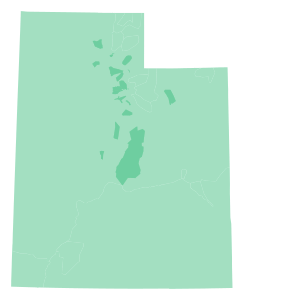

Index(['FID', 'SSNFACGEO', 'COFACGEO', 'WDFACGEO', 'SHAPE'], dtype='object')

In [70]:
display(sdfGeographies.spatial)
sdfGeographies.columns

In [71]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map5 = gis.map('Salt Lake')

#define sdf layer
sdfGeographies.spatial.plot(map_widget=map5,renderer_type='u',col='COFACGEO',default_symbol="",cmap='nipy_spectral',alpha=0.7)

map5.layout.height='700px'
map5.legend=True

#add map title
display(Markdown('<h2><center>Combined Group Geographies</center></h2>'))

#display the map
map5

<h2><center>Combined Group Geographies</center></h2>

MapView(layout=Layout(height='700px', width='100%'), legend=True)

In [72]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map6 = gis.map('Salt Lake')

#define sdf layer
sdfGeographies.spatial.plot(map_widget=map6,renderer_type='u',col='WDFACGEO',default_symbol="",cmap='nipy_spectral',alpha=0.7)

map6.layout.height='700px'
map6.legend=True

#add map title
display(Markdown('<h2><center>Combined Group Geographies</center></h2>'))

#display the map
map6

<h2><center>Combined Group Geographies</center></h2>

MapView(layout=Layout(height='700px', width='100%'), legend=True)

In [51]:
#get color ramp info

#from arcgis.mapping import symbol
#
#colormaps = symbol.ALLOWED_CMAPS
#for a,b,c,d,e in zip(colormaps[::5], colormaps[1::5], colormaps[2::5], colormaps[3::5], colormaps[4::5]):
#    print("{:<20}{:<20}{:<20}{:<20}{:<}".format(a,b,c,d,e))
#symbol.display_colormaps(['Greens_r', 'PRGn', 'Dark2', 'nipy_spectral'])

In [73]:
#export to geodatabase in order to use arcpy join features, etc
sdfGeographies.spatial.to_featureclass(location=fcGeographies, sanitize_columns=False)

'd:\\GitHub\\UDOT-Segment-Factors\\intermediate\\process.gdb\\Geographies'

In [74]:
#create segment definition for each geography...
#need to dissolve for factor group that may share different shape in geography feature class

dfSegmentsGeo_Combined = pd.DataFrame(columns = ['SEGID','FACGEOGROUP','FACGEO'])


for sGeoFieldName in lGeoFieldNames:
    display("Obtaining geographies from field: " + sGeoFieldName)
    fcGeographiesDissolve = os.path.join(dirIntermediate, ProcessGDB + "\GeographiesDissolve_" + sGeoFieldName)    
    fcSegmentsGeographies = os.path.join(dirIntermediate, ProcessGDB + "\SegmentsGeographiesIntersect_" + sGeoFieldName)
    
    deleteIfExists(fcGeographiesDissolve)
    arcpy.management.Dissolve(fcGeographies, fcGeographiesDissolve, sGeoFieldName)
    
    deleteIfExists(fcSegmentsGeographies)
    arcpy.analysis.Intersect([fcSegmentsWithAADT,fcGeographiesDissolve],fcSegmentsGeographies)

    # Execute DeleteField
    arcpy.AddField_management(fcSegmentsGeographies, "PIECELENGTH" , "DOUBLE")
    arcpy.CalculateField_management(fcSegmentsGeographies,
                                    "PIECELENGTH",
                                    "!shape.length@miles!",
                                    "PYTHON_9.3")
    
    sdfSegmentsGeographies = pd.DataFrame.spatial.from_featureclass(fcSegmentsGeographies)
    dfSegmentsGeographies_MaxLength = sdfSegmentsGeographies.groupby('SEGID',as_index=False).agg(MAXPIECELEN=('PIECELENGTH','max'))
    display(dfSegmentsGeographies_MaxLength)
    
    dfSegmentsGeo = pd.DataFrame.merge(sdfSegmentsGeographies,dfSegmentsGeographies_MaxLength,left_on=('SEGID','PIECELENGTH'),right_on=('SEGID','MAXPIECELEN'))
    dfSegmentsGeo = dfSegmentsGeo[['SEGID',sGeoFieldName]]
    dfSegmentsGeo.columns = ('SEGID','FACGEO')
    dfSegmentsGeo['FACGEOGROUP'] = sGeoFieldName
    
    dfSegmentsGeo_Combined = dfSegmentsGeo_Combined.append(dfSegmentsGeo, ignore_index=True)

    display(dfSegmentsGeo)

display(dfSegmentsGeo_Combined)

'Obtaining geographies from field: WDFACGEO'

,SEGID,MAXPIECELEN
0,0006_000.0,0.666641
1,0006_000.7,15.369839
2,0006_016.0,30.001961
3,0006_046.0,14.194306
4,0006_060.2,17.323237
...,...,...
8717,WFRC_8262,0.420118
8718,WFRC_8263,0.470365
8719,WFRC_8264,0.448309
8720,WFRC_8265,0.298847


C:\Users\cday\AppData\Local\Temp\ipykernel_182096\1278590701.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfSegmentsGeo_Combined = dfSegmentsGeo_Combined.append(dfSegmentsGeo, ignore_index=True)


,SEGID,FACGEO,FACGEOGROUP
0,0006_000.0,Statewide,WDFACGEO
1,0006_000.7,Statewide,WDFACGEO
2,0006_016.0,Statewide,WDFACGEO
3,0006_046.0,Statewide,WDFACGEO
4,0006_060.2,Statewide,WDFACGEO
...,...,...,...
8717,Dixie_5134,Statewide,WDFACGEO
8718,MAG_6055,Statewide,WDFACGEO
8719,MAG_6057,Statewide,WDFACGEO
8720,MAG_6058,Statewide,WDFACGEO


'Obtaining geographies from field: SSNFACGEO'

,SEGID,MAXPIECELEN
0,0006_000.0,0.666641
1,0006_000.7,15.369839
2,0006_016.0,30.001961
3,0006_046.0,14.194306
4,0006_060.2,17.323237
...,...,...
8717,WFRC_8262,0.420118
8718,WFRC_8263,0.470365
8719,WFRC_8264,0.448309
8720,WFRC_8265,0.298847


C:\Users\cday\AppData\Local\Temp\ipykernel_182096\1278590701.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfSegmentsGeo_Combined = dfSegmentsGeo_Combined.append(dfSegmentsGeo, ignore_index=True)


,SEGID,FACGEO,FACGEOGROUP
0,0006_000.0,Statewide,SSNFACGEO
1,0006_000.7,Statewide,SSNFACGEO
2,0006_016.0,Statewide,SSNFACGEO
3,0006_046.0,Statewide,SSNFACGEO
4,0006_060.2,Statewide,SSNFACGEO
...,...,...,...
8717,Dixie_5134,Washington,SSNFACGEO
8718,MAG_6055,Statewide,SSNFACGEO
8719,MAG_6057,Statewide,SSNFACGEO
8720,MAG_6058,Statewide,SSNFACGEO


'Obtaining geographies from field: COFACGEO'

,SEGID,MAXPIECELEN
0,0006_000.0,0.666641
1,0006_000.7,15.369839
2,0006_016.0,30.001961
3,0006_046.0,14.194306
4,0006_060.2,17.323237
...,...,...
8717,WFRC_8262,0.420118
8718,WFRC_8263,0.470365
8719,WFRC_8264,0.448309
8720,WFRC_8265,0.298847


C:\Users\cday\AppData\Local\Temp\ipykernel_182096\1278590701.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfSegmentsGeo_Combined = dfSegmentsGeo_Combined.append(dfSegmentsGeo, ignore_index=True)


,SEGID,FACGEO,FACGEOGROUP
0,0006_000.0,Statewide,COFACGEO
1,0006_000.7,Statewide,COFACGEO
2,0006_016.0,Statewide,COFACGEO
3,0006_046.0,Statewide,COFACGEO
4,0006_060.2,Statewide,COFACGEO
...,...,...,...
8717,Dixie_5134,Washington,COFACGEO
8718,MAG_6055,Statewide,COFACGEO
8719,MAG_6057,Statewide,COFACGEO
8720,MAG_6058,Statewide,COFACGEO


,SEGID,FACGEOGROUP,FACGEO
0,0006_000.0,WDFACGEO,Statewide
1,0006_000.7,WDFACGEO,Statewide
2,0006_016.0,WDFACGEO,Statewide
3,0006_046.0,WDFACGEO,Statewide
4,0006_060.2,WDFACGEO,Statewide
...,...,...,...
26161,Dixie_5134,COFACGEO,Washington
26162,MAG_6055,COFACGEO,Statewide
26163,MAG_6057,COFACGEO,Statewide
26164,MAG_6058,COFACGEO,Statewide


In [76]:
sdfSegmentsGeographies[sdfSegmentsGeographies['SEGID']=='1692_004.0']

,OBJECTID,FID_SegmentsWithAADT,SEGID,AADT2019,SEGLENGTH,FID_GeographiesDissolve_COFACGEO,COFACGEO,PIECELENGTH,SHAPE
1689,1690,1680,1692_004.0,232.0,2.33977,6,Moab,2.33977,"{""paths"": [[[628632.7999999998, 4268191.199999..."


In [77]:
# Check if each segment has the right number of FACGEOs

dfSegmentsGeo_Combined_count = dfSegmentsGeo_Combined.groupby(['SEGID'],as_index=False).agg(NUMREC=('FACGEO','size'))
dfSegmentsGeo_Combined_missinggeo = dfSegmentsGeo_Combined_count[dfSegmentsGeo_Combined_count['NUMREC']!=len(lGeoFieldNames)]
display("SEGMENTS WITH MISSING GEOS... CORRECT BEFORE PROCEECING:")
display(dfSegmentsGeo_Combined_missinggeo)

'SEGMENTS WITH MISSING GEOS... CORRECT BEFORE PROCEECING:'

,SEGID,NUMREC


In [78]:
#change list to dataframe
dfGeoFieldNames = pd.DataFrame(lGeoFieldNames,columns=['FACGEOGROUP'])

#cross join, creating records for each geo field name
sdfSegmentsAADT_AT_FacGeo = pd.DataFrame.merge(sdfSegmentsWithAADT_AT_wOverride,dfGeoFieldNames,how='cross')                                            
                                               
sdfSegAADTATGeo = pd.DataFrame.merge(sdfSegmentsAADT_AT_FacGeo,dfSegmentsGeo_Combined,on=('SEGID','FACGEOGROUP'),how='outer')
sdfSegAADTATGeoFTGroup = pd.DataFrame.merge(sdfSegAADTATGeo,dfAllSegFTGroup,on='SEGID')
sdfSegAADTATGeoFTGroup['ROUTE'] =  sdfSegAADTATGeoFTGroup['SEGID'].str.split('_').str[0] #get all before first underscore
sdfSegAADTATGeoFTGroup['MP'   ] =  sdfSegAADTATGeoFTGroup['SEGID'].str.split('_').str[1].astype(float) #get all after first underscore
sdfSegAADTATGeoFTGroup

,OBJECTID,SEGID,AADT2019,SEGLENGTH,SHAPE,AREATYPE,ATOVERRIDE,NOTE,FACGEOGROUP,FACGEO,FTGROUP,ROUTE,MP
0,1,0006_000.0,415.0,0.666641,"{'paths': [[[236177.7000000002, 4327541.25], [...",1.0,0.0,,WDFACGEO,Statewide,Arterial,0006,0.0
1,1,0006_000.0,415.0,0.666641,"{'paths': [[[236177.7000000002, 4327541.25], [...",1.0,0.0,,SSNFACGEO,Statewide,Arterial,0006,0.0
2,1,0006_000.0,415.0,0.666641,"{'paths': [[[236177.7000000002, 4327541.25], [...",1.0,0.0,,COFACGEO,Statewide,Arterial,0006,0.0
3,2,0006_000.7,415.0,15.369839,"{'paths': [[[237241.1799999997, 4327399.720000...",1.0,0.0,,WDFACGEO,Statewide,Arterial,0006,0.7
4,2,0006_000.7,415.0,15.369839,"{'paths': [[[237241.1799999997, 4327399.720000...",1.0,0.0,,SSNFACGEO,Statewide,Arterial,0006,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26161,8721,1760_000.0,713.0,0.669243,"{'paths': [[[317053.5, 4170842.6999999993], [3...",3.0,0.0,,SSNFACGEO,Statewide,Arterial,1760,0.0
26162,8721,1760_000.0,713.0,0.669243,"{'paths': [[[317053.5, 4170842.6999999993], [3...",3.0,0.0,,COFACGEO,Statewide,Arterial,1760,0.0
26163,8722,Dixie_5134,0.0,1.235881,"{'paths': [[[281099.17870000005, 4097699.47849...",1.0,0.0,,WDFACGEO,Statewide,Arterial,Dixie,5134.0
26164,8722,Dixie_5134,0.0,1.235881,"{'paths': [[[281099.17870000005, 4097699.47849...",1.0,0.0,,SSNFACGEO,Washington,Arterial,Dixie,5134.0


In [79]:
# update FACGEO for non-geography shapefile defined segments (e.g. many freeways)
sdfFacGeoOverride = pd.DataFrame.merge(sdfSegAADTATGeoFTGroup,prmStationGrpToFacGrpFieldsFacGeoOverride,on=('ROUTE','FACGEOGROUP'))
sdfFacGeoOverride = sdfFacGeoOverride[((sdfFacGeoOverride['MP']>=sdfFacGeoOverride['MPFROM']) & (sdfFacGeoOverride['MP']<=sdfFacGeoOverride['MPTO']))]

dfFacGeoOverride = sdfFacGeoOverride[['SEGID','FACGEOGROUP','FACGEO_NEW']]
#display(dfFacGeoOverride)

sdfSegAADTATGeoFTGroup_wOverrides = pd.DataFrame.merge(sdfSegAADTATGeoFTGroup,dfFacGeoOverride,on=('SEGID','FACGEOGROUP'),how='left')
sdfSegAADTATGeoFTGroup_wOverrides.loc[~(sdfSegAADTATGeoFTGroup_wOverrides['FACGEO_NEW'].isna()),'FACGEO'] = sdfSegAADTATGeoFTGroup_wOverrides['FACGEO_NEW']
display(sdfSegAADTATGeoFTGroup_wOverrides[~sdfSegAADTATGeoFTGroup_wOverrides['FACGEO_NEW'].isna()])
sdfSegAADTATGeoFTGroup_wOverrides = sdfSegAADTATGeoFTGroup_wOverrides[['SEGID','AADT2019','AREATYPE','FACGEOGROUP','FACGEO','FTGROUP','SHAPE']]
display(sdfSegAADTATGeoFTGroup_wOverrides)

,OBJECTID,SEGID,AADT2019,SEGLENGTH,SHAPE,AREATYPE,ATOVERRIDE,NOTE,FACGEOGROUP,FACGEO,FTGROUP,ROUTE,MP,FACGEO_NEW
393,132,0015_101.2,22813.0,7.584925,"{'paths': [[[358793.4199999999, 4223468.119999...",1.0,0.0,,WDFACGEO,I15,Freeway,0015,101.2,I15
394,132,0015_101.2,22813.0,7.584925,"{'paths': [[[358793.4199999999, 4223468.119999...",1.0,0.0,,SSNFACGEO,I15,Freeway,0015,101.2,I15
395,132,0015_101.2,22813.0,7.584925,"{'paths': [[[358793.4199999999, 4223468.119999...",1.0,0.0,,COFACGEO,I15,Freeway,0015,101.2,I15
396,133,0015_108.7,20647.0,3.042169,"{'paths': [[[355631.5399000002, 4234760.989700...",1.0,1.0,through Beaver make rural,WDFACGEO,I15,Freeway,0015,108.7,I15
397,133,0015_108.7,20647.0,3.042169,"{'paths': [[[355631.5399000002, 4234760.989700...",1.0,1.0,through Beaver make rural,SSNFACGEO,I15,Freeway,0015,108.7,I15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26143,8715,0015_056.8,31816.0,2.033991,"{'paths': [[[316188.0999999996, 4169194.650000...",3.0,0.0,,SSNFACGEO,I15,Freeway,0015,56.8,I15
26144,8715,0015_056.8,31816.0,2.033991,"{'paths': [[[316188.0999999996, 4169194.650000...",3.0,0.0,,COFACGEO,I15,Freeway,0015,56.8,I15
26145,8716,0015_058.8,31179.0,3.686742,"{'paths': [[[316609.4000000004, 4172409.679999...",2.0,0.0,,WDFACGEO,I15,Freeway,0015,58.8,I15
26146,8716,0015_058.8,31179.0,3.686742,"{'paths': [[[316609.4000000004, 4172409.679999...",2.0,0.0,,SSNFACGEO,I15,Freeway,0015,58.8,I15


,SEGID,AADT2019,AREATYPE,FACGEOGROUP,FACGEO,FTGROUP,SHAPE
0,0006_000.0,415.0,1.0,WDFACGEO,Statewide,Arterial,"{'paths': [[[236177.7000000002, 4327541.25], [..."
1,0006_000.0,415.0,1.0,SSNFACGEO,Statewide,Arterial,"{'paths': [[[236177.7000000002, 4327541.25], [..."
2,0006_000.0,415.0,1.0,COFACGEO,Statewide,Arterial,"{'paths': [[[236177.7000000002, 4327541.25], [..."
3,0006_000.7,415.0,1.0,WDFACGEO,Statewide,Arterial,"{'paths': [[[237241.1799999997, 4327399.720000..."
4,0006_000.7,415.0,1.0,SSNFACGEO,Statewide,Arterial,"{'paths': [[[237241.1799999997, 4327399.720000..."
...,...,...,...,...,...,...,...
26161,1760_000.0,713.0,3.0,SSNFACGEO,Statewide,Arterial,"{'paths': [[[317053.5, 4170842.6999999993], [3..."
26162,1760_000.0,713.0,3.0,COFACGEO,Statewide,Arterial,"{'paths': [[[317053.5, 4170842.6999999993], [3..."
26163,Dixie_5134,0.0,1.0,WDFACGEO,Statewide,Arterial,"{'paths': [[[281099.17870000005, 4097699.47849..."
26164,Dixie_5134,0.0,1.0,SSNFACGEO,Washington,Arterial,"{'paths': [[[281099.17870000005, 4097699.47849..."


In [80]:
#check if amy duplication of segments occurred
dfCount = sdfSegAADTATGeoFTGroup_wOverrides.groupby(['SEGID','FACGEOGROUP'],as_index=False).agg(COUNT=('AADT2019','size'))
dfCount = dfCount[dfCount['COUNT']>1]
dfCount

,SEGID,FACGEOGROUP,COUNT


In [81]:
#FT Overrides
dfFTGroupOverride = pd.read_csv(fnFTGroupOverride)
display(dfFTGroupOverride)

sdfSegFacMatch_FTOverride = pd.DataFrame.merge(sdfSegAADTATGeoFTGroup_wOverrides,dfFTGroupOverride,on='SEGID',how='left')

#override FTGROUP
sdfSegFacMatch_FTOverride.loc[~(sdfSegFacMatch_FTOverride['FTGROUP_NEW'].isna()),'FTGROUP'] = sdfSegFacMatch_FTOverride['FTGROUP_NEW']

#change to FTGROUP_NEW to flag
sdfSegFacMatch_FTOverride.loc[~(sdfSegFacMatch_FTOverride['FTGROUP_NEW'].isna()),'FTGROUP_NEW'] = 1

#show overriden records
sdfSegFacMatch_FTOverride[sdfSegFacMatch_FTOverride['FTGROUP_NEW']==1]

sdfSegFacMatch = pd.DataFrame.merge(sdfSegFacMatch_FTOverride,dfFacFieldLookup,on=('FACGEOGROUP','FACGEO','FTGROUP','AREATYPE'),how='left')

sdfSegFacMatchFacGroup = sdfSegFacMatch[((sdfSegFacMatch['AADT2019']>=sdfSegFacMatch['VOLUMEFROM']) & (sdfSegFacMatch['AADT2019']<sdfSegFacMatch['VOLUMETO']))]
#show rows with matching records
#display(sdfSegFacMatchFacGroup)

sdfSegFacMatch2 = pd.DataFrame.merge(sdfSegFacMatch_FTOverride,sdfSegFacMatchFacGroup,on=('SEGID','FACGEOGROUP','FACGEO','FTGROUP','AREATYPE','AADT2019','SHAPE'),how='left')
display("unmatched:")
display(sdfSegFacMatch2[sdfSegFacMatch2['STATIONGROUP'].isna()])

sdfSegFacMatch2 = sdfSegFacMatch2[['SEGID','AADT2019','AREATYPE','FACGEOGROUP','FACGEO','FTGROUP','STATIONGROUP','SHAPE']]
display("final table:")
display(sdfSegFacMatch2)


,SEGID,FTGROUP_NEW,NOTE
0,0040_008.2,Freeway,US40 just north of Heber
1,0080_155.0,Freeway,no links in TDM
2,Dixie_5134,Arterial,new road piece just over AZ border
3,0067_004.0,Freeway,need to fix SEGID in TDM
4,0201_000.0,Freeway,treat 201 the same as freeway portion for factors
...,...,...,...
41,0018_003.8,Expressway,NaN
42,0018_007.6,Expressway,NaN
43,0018_008.6,Expressway,NaN
44,Dixie_5176,Freeway,St George Southern Parkway


'unmatched:'

,SEGID,AADT2019,AREATYPE,FACGEOGROUP,FACGEO,FTGROUP,SHAPE,FTGROUP_NEW_x,NOTE_x,FTGROUP_NEW_y,NOTE_y,VOLUMEFROM,VOLUMETO,STATIONGROUP
8958,0080_128.7,58852.0,1.0,WDFACGEO,I80,Arterial,"{'paths': [[[433362, 4507122.73], [433392.7999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8959,0080_128.7,58852.0,1.0,SSNFACGEO,I80,Arterial,"{'paths': [[[433362, 4507122.73], [433392.7999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8960,0080_128.7,58852.0,1.0,COFACGEO,I80SR186US40,Arterial,"{'paths': [[[433362, 4507122.73], [433392.7999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8961,0080_130.4,58978.0,1.0,WDFACGEO,I80,Arterial,"{'paths': [[[435390.33999999985, 4508894.27999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8962,0080_130.4,58978.0,1.0,SSNFACGEO,I80,Arterial,"{'paths': [[[435390.33999999985, 4508894.27999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,0080_133.7,57491.0,1.0,SSNFACGEO,I80,Arterial,"{'paths': [[[439734.3799999999, 4511421.189999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8969,0080_133.7,57491.0,1.0,COFACGEO,I80SR186US40,Arterial,"{'paths': [[[439734.3799999999, 4511421.189999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
24501,0080_167.3,14629.0,1.0,WDFACGEO,I80,Arterial,"{'paths': [[[463105.1200000001, 4535575.369999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
24502,0080_167.3,14629.0,1.0,SSNFACGEO,I80,Arterial,"{'paths': [[[463105.1200000001, 4535575.369999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


'final table:'

,SEGID,AADT2019,AREATYPE,FACGEOGROUP,FACGEO,FTGROUP,STATIONGROUP,SHAPE
0,0006_000.0,415.0,1.0,WDFACGEO,Statewide,Arterial,WD0,"{'paths': [[[236177.7000000002, 4327541.25], [..."
1,0006_000.0,415.0,1.0,SSNFACGEO,Statewide,Arterial,SNP,"{'paths': [[[236177.7000000002, 4327541.25], [..."
2,0006_000.0,415.0,1.0,COFACGEO,Statewide,Arterial,COP,"{'paths': [[[236177.7000000002, 4327541.25], [..."
3,0006_000.7,415.0,1.0,WDFACGEO,Statewide,Arterial,WD0,"{'paths': [[[237241.1799999997, 4327399.720000..."
4,0006_000.7,415.0,1.0,SSNFACGEO,Statewide,Arterial,SNP,"{'paths': [[[237241.1799999997, 4327399.720000..."
...,...,...,...,...,...,...,...,...
26161,1760_000.0,713.0,3.0,SSNFACGEO,Statewide,Arterial,SNT,"{'paths': [[[317053.5, 4170842.6999999993], [3..."
26162,1760_000.0,713.0,3.0,COFACGEO,Statewide,Arterial,COT,"{'paths': [[[317053.5, 4170842.6999999993], [3..."
26163,Dixie_5134,0.0,1.0,WDFACGEO,Statewide,Arterial,WD0,"{'paths': [[[281099.17870000005, 4097699.47849..."
26164,Dixie_5134,0.0,1.0,SSNFACGEO,Washington,Arterial,SNV,"{'paths': [[[281099.17870000005, 4097699.47849..."


In [89]:
sdfSegFacMatch2[sdfSegFacMatch2['FACGEO'].str.contains('I15')]

,SEGID,AADT2019,AREATYPE,FACGEOGROUP,FACGEO,FTGROUP,STATIONGROUP,SHAPE
393,0015_101.2,22813.0,1.0,WDFACGEO,I15,Freeway,WD8,"{'paths': [[[358793.4199999999, 4223468.119999..."
394,0015_101.2,22813.0,1.0,SSNFACGEO,I15,Freeway,SN4,"{'paths': [[[358793.4199999999, 4223468.119999..."
395,0015_101.2,22813.0,1.0,COFACGEO,I15,Freeway,CO4,"{'paths': [[[358793.4199999999, 4223468.119999..."
396,0015_108.7,20647.0,1.0,WDFACGEO,I15,Freeway,WD8,"{'paths': [[[355631.5399000002, 4234760.989700..."
397,0015_108.7,20647.0,1.0,SSNFACGEO,I15,Freeway,SN4,"{'paths': [[[355631.5399000002, 4234760.989700..."
...,...,...,...,...,...,...,...,...
26143,0015_056.8,31816.0,3.0,SSNFACGEO,I15,Freeway,SN6,"{'paths': [[[316188.0999999996, 4169194.650000..."
26144,0015_056.8,31816.0,3.0,COFACGEO,I15,Freeway,CO6,"{'paths': [[[316188.0999999996, 4169194.650000..."
26145,0015_058.8,31179.0,2.0,WDFACGEO,I15,Freeway,WD9,"{'paths': [[[316609.4000000004, 4172409.679999..."
26146,0015_058.8,31179.0,2.0,SSNFACGEO,I15,Freeway,SN5,"{'paths': [[[316609.4000000004, 4172409.679999..."


In [82]:
#another check for unmatched segments
dfUnmatched = pd.DataFrame.merge(dfAllSegIDs,sdfSegFacMatch2,on='SEGID',how='left')
dfUnmatched = dfUnmatched[dfUnmatched['STATIONGROUP'].isna()]
dfUnmatched

,SEGID,AADT2019,AREATYPE,FACGEOGROUP,FACGEO,FTGROUP,STATIONGROUP,SHAPE
8958,0080_128.7,58852.0,1.0,WDFACGEO,I80,Arterial,NaN,"{'paths': [[[433362, 4507122.73], [433392.7999..."
8959,0080_128.7,58852.0,1.0,SSNFACGEO,I80,Arterial,NaN,"{'paths': [[[433362, 4507122.73], [433392.7999..."
8960,0080_128.7,58852.0,1.0,COFACGEO,I80SR186US40,Arterial,NaN,"{'paths': [[[433362, 4507122.73], [433392.7999..."
8961,0080_130.4,58978.0,1.0,WDFACGEO,I80,Arterial,NaN,"{'paths': [[[435390.33999999985, 4508894.27999..."
8962,0080_130.4,58978.0,1.0,SSNFACGEO,I80,Arterial,NaN,"{'paths': [[[435390.33999999985, 4508894.27999..."
...,...,...,...,...,...,...,...,...
8968,0080_133.7,57491.0,1.0,SSNFACGEO,I80,Arterial,NaN,"{'paths': [[[439734.3799999999, 4511421.189999..."
8969,0080_133.7,57491.0,1.0,COFACGEO,I80SR186US40,Arterial,NaN,"{'paths': [[[439734.3799999999, 4511421.189999..."
24501,0080_167.3,14629.0,1.0,WDFACGEO,I80,Arterial,NaN,"{'paths': [[[463105.1200000001, 4535575.369999..."
24502,0080_167.3,14629.0,1.0,SSNFACGEO,I80,Arterial,NaN,"{'paths': [[[463105.1200000001, 4535575.369999..."


In [83]:
sdfSegFacMatch2_duplicates = sdfSegFacMatch2.groupby(['SEGID','AADT2019','AREATYPE'],as_index=False).agg(COUNT=('FACGEOGROUP','size'))
sdfSegFacMatch2_duplicates[sdfSegFacMatch2_duplicates['COUNT']!=len(lGeoFieldNames)]

,SEGID,AADT2019,AREATYPE,COUNT


In [62]:
sdfSegFacMatch2_tocsv = sdfSegFacMatch2[['SEGID','AADT2019','AREATYPE','FTGROUP','FACGEO','STATIONGROUP']]
sdfSegFacMatch2_tocsv.to_csv(os.path.join(dirIntermediate, 'SegmentsMatchedToFactorGroups.csv'),index=False)

In [63]:
sdfSegFacMatch2_pivot = sdfSegFacMatch2.pivot(index=('SEGID','AADT2019','AREATYPE','SHAPE'), columns='FACGEOGROUP', values='STATIONGROUP')
sdfSegFacMatch2_pivot = sdfSegFacMatch2_pivot.reset_index()
sdfSegFacMatch2_pivot

FACGEOGROUP,SEGID,AADT2019,AREATYPE,SHAPE,COFACGEO,SSNFACGEO,WDFACGEO
0,0006_000.0,415.0,1.0,"{'paths': [[[236177.7000000002, 4327541.25], [...",COP,SNP,WD0
1,0006_000.7,415.0,1.0,"{'paths': [[[237241.1799999997, 4327399.720000...",COP,SNP,WD0
2,0006_016.0,415.0,1.0,"{'paths': [[[261403.90000000037, 4327045.4], [...",COP,SNP,WD0
3,0006_046.0,372.0,1.0,"{'paths': [[[305380.16000000015, 4325741.85], ...",COP,SNP,WD0
4,0006_060.2,372.0,1.0,"{'paths': [[[324618, 4337936.9], [324647.40000...",COP,SNP,WD0
...,...,...,...,...,...,...,...
8558,WFRC_8219,0.0,2.0,"{'paths': [[[419504.53110000025, 4554272.0693]...",COS,SNS,WD1
8559,WFRC_8220,0.0,3.0,"{'paths': [[[415710.1200000001, 4495585.710000...",COT,SNT,WD2
8560,WFRC_8221,0.0,4.0,"{'paths': [[[423366.5, 4492605.300000001], [42...",COU,SNU,WD3
8561,WFRC_8222,0.0,4.0,"{'paths': [[[423433.7000000002, 4493180.6], [4...",COU,SNU,WD3


In [64]:
sdfSegFacMatch2_pivot.spatial.to_featureclass(location=os.path.join(dirResults, r'layers\SegmentsWithFactorGroups.shp'), sanitize_columns=False)

'E:\\GitHub\\UDOT-Segment-Factors\\results\\layers\\SegmentsWithFactorGroups.shp'

In [65]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map8 = gis.map('Salt Lake')

#define sdf layer
sdfSegFacMatch2_pivot.spatial.plot(map_widget=map8,renderer_type='u',col='COFACGEO',default_symbol="",cmap='nipy_spectral',alpha=0.7)

map8.layout.height='700px'
map8.legend=True

#add map title
display(Markdown('<h2><center>Segments by Group Geographies</center></h2>'))

#display the map
map8

<h2><center>Segments by Group Geographies</center></h2>

MapView(layout=Layout(height='700px', width='100%'), legend=True)